# Advanced Tutorial 11: Model Calibration

## Overview
In this tutorial, we will discuss the following topics:
* [Calculating Calibration Error](#ta11error)
* [Generating and Applying a Model Calibrator](#ta11calibrator)

We'll start by getting the imports out of the way:

In [1]:
import tempfile
import os

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze, reduce_mean
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize, Calibrate
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.summary.logs import visualize_logs
from fastestimator.trace.adapt import PBMCalibrator
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import CalibrationError, MCC
from fastestimator.util import to_number, to_list

import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

And let's define a function to build a generic ciFAIR10 estimator. We will show how to use combinations of extra traces and post-processing ops to enhance this estimator throughout the tutorial.

In [2]:
def build_estimator(extra_traces = None, postprocessing_ops = None):
    batch_size=128
    save_dir = tempfile.mkdtemp()
    extra_traces = to_list(extra_traces)
    postprocessing_ops = to_list(postprocessing_ops)
    train_data, eval_data = cifair10.load_data()
    test_data = eval_data.split(range(len(eval_data) // 2))
    pipeline = fe.Pipeline(
        train_data=train_data,
        eval_data=eval_data,
        test_data=test_data,
        batch_size=batch_size,
        ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
             PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
             RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
             Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
             CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
             ],
        num_process=0)

    model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
    network = fe.Network(
        ops=[
            ModelOp(model=model, inputs="x", outputs="y_pred"),
            CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
            UpdateOp(model=model, loss_name="ce")
        ], 
        pops=postprocessing_ops)  # <---- Some of the secret sauce will go here

    traces = [
        MCC(true_key="y", pred_key="y_pred"),
        BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    ]
    traces = traces + extra_traces  # <---- Most of the secret sauce will go here
    estimator = fe.Estimator(pipeline=pipeline,
                             network=network,
                             epochs=21,
                             traces=traces,
                             log_steps=300)
    return estimator

<a id='ta11error'></a>

## Calculating Calibration Error

Suppose you have a neural network that is performing image classification. For the sake of argument, let's imagine that the classification problem is to look at x-ray images and determine whether or not a patient has cancer. Let's further suppose that your model is very accurate: when it assigns a higher probability to 'cancer' the patient is almost always sick, and when it assigns a higher probability to 'healthy' the patient is almost always fine. It could be tempting to think that the job is done, but there is still a potential problem for real-world deployments of your model. Suppose a physician using your model runs an image and gets a report saying that it is 51% likely that the patient is healthy, and 49% likely that there is a cancerous tumor. In reality the patient is indeed healthy. From an accuracy point of view, your model is doing just fine. However, if the doctor sees that it is 49% likely that there is a tumor, they are likely to order a biopsy in order to be on the safe side. Taken to an extreme, suppose that your model always predicts a 49% probability of a tumor whenever it sees a healthy patient. Even though the model might have perfect accuracy, in practice it would always result in extra surgical procedures being performed. Ideally, if the model says that there is a 49% probability of a tumor, you would expect there to actually be a tumor in 49% of those cases. The discrepancy between a models predicted probability of a class and the true probability of that class conditioned on the prediction is measured as the calibration error. Calibration error is notoriously difficult to estimate correctly, but FE provides a `Trace` for this based on a [2019 NeurIPS spotlight paper](https://papers.nips.cc/paper/2019/file/f8c0c968632845cd133308b1a494967f-Paper.pdf) titled "Verified Uncertainty Calibration". 

The `CalibrationError` trace can be used just like any other metric trace, though it also optionally can compute confidence intervals around the estimated error. Keep in mind that to measure calibration error you would want your validation dataset to have a reasonable real-world class distribution (only a small percentage of people in the population actually have cancer, for example). For the purpose of easy illustration we will be using the ciFAIR10 dataset, and computing a 95% confidence interval for the estimated calibration error of the model:

In [3]:
estimator = build_estimator(extra_traces=CalibrationError(true_key="y", pred_key="y_pred", confidence_interval=95))

In [4]:
summary = estimator.fit("experiment1")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3128014;
FastEstimator-Train: step: 300; ce: 1.5598099; steps/sec: 24.91;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 16.58 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpkuy03g7x/model_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; calibration_error: (0.0297, 0.0334, 0.0376); ce: 1.3315556; max_mcc: 0.46224125252635423; mcc: 0.46224125252635423; since_best_mcc: 0;
FastEstimator-Trai

In [5]:
estimator.test()

FastEstimator-Test: step: 8211; epoch: 21; calibration_error: (0.0226, 0.0279, 0.0345); ce: 0.6998544; mcc: 0.7373376975856221;


Let's take a look at how the calibration error changed over training:

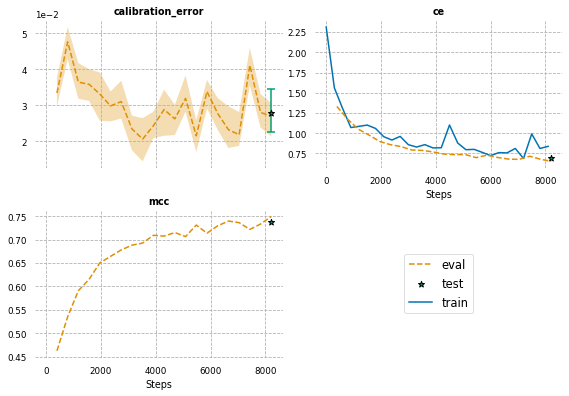

In [6]:
visualize_logs([summary], include_metrics={'calibration_error', 'mcc', 'ce'})

As we can see from the graph above, calibration error is significantly more noisy than classical metrics like mcc or accuracy. In this case it does seem to have improved somewhat with training, though the correlation isn't strong enough to expect to be able to eliminate your calibration error just by training longer. Instead, we will see how you can effectively calibrate a model after-the-fact:

<a id='ta11calibrator'></a>

## Generating and Applying a Model Calibrator

While there have been many proposed approaches for model calibration, we will again be leveraging the Verified Uncertainty Calibration paper mentioned above to achieve highly sample-efficient model re-calibration. There are two steps involved here. The first step is that we will use the `PBMCalibrator` trace to generate a 'platt binner marginal calibrator'. This calibrator is separate from the neural network, but will take neural network outputs and return calibrated outputs. A consequence of performing this calibration is that the output vector for a prediction will no longer sum to 1, since each class is calibrated independently. 

Of course, simply having such a calibration object is not useful if we don't use it. To make use of our calibrator object we will use the `Calibrate` numpyOp, which can load any calibrator object from disk and then apply it during `Network` post-processing. Since we are using a best model saver, we will only save the calibrator object when our since_best is 0 so that when we re-load the best model we will also be loading the correct calibrator for that model.  

In [7]:
save_path = os.path.join(tempfile.mkdtemp(), 'calibrator.pkl')
estimator = build_estimator(extra_traces=[CalibrationError(true_key="y", pred_key="y_pred", confidence_interval=95), 
                                          PBMCalibrator(true_key="y", pred_key="y_pred", save_path=save_path, save_if_key="since_best_mcc", mode="eval"),
                                          # We will also compare the MCC and calibration error between the original and calibrated samples:
                                          MCC(true_key="y", pred_key="y_pred_calibrated", output_name="mcc (calibrated)", mode="test"),
                                          CalibrationError(true_key="y", pred_key="y_pred_calibrated", output_name="calibration_error (calibrated)", confidence_interval=95, mode="test"), 
                                          ],
                           postprocessing_ops = Calibrate(inputs="y_pred", outputs="y_pred_calibrated", calibration_fn=save_path, mode="test"))

In [8]:
summary = estimator.fit("experiment2")

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3104477;
FastEstimator-Train: step: 300; ce: 1.4325299; steps/sec: 22.16;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 18.26 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppvkulhpx/model1_best_mcc.h5
FastEstimator-PBMCalibrator: Calibrator written to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpsgbutr41/calibrator.pkl
FastEstimator-Eval: step: 391; epoch: 1; calibration_error: (0.045

In [9]:
estimator.test()

FastEstimator-Calibrate: calibration function loaded from /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpsgbutr41/calibrator.pkl
FastEstimator-Test: step: 8211; epoch: 21; calibration_error: (0.0204, 0.0242, 0.03); calibration_error (calibrated): (0.0012, 0.0047, 0.0088); ce: 0.7153029; mcc: 0.7339172532443659; mcc (calibrated): 0.7296598230150076;


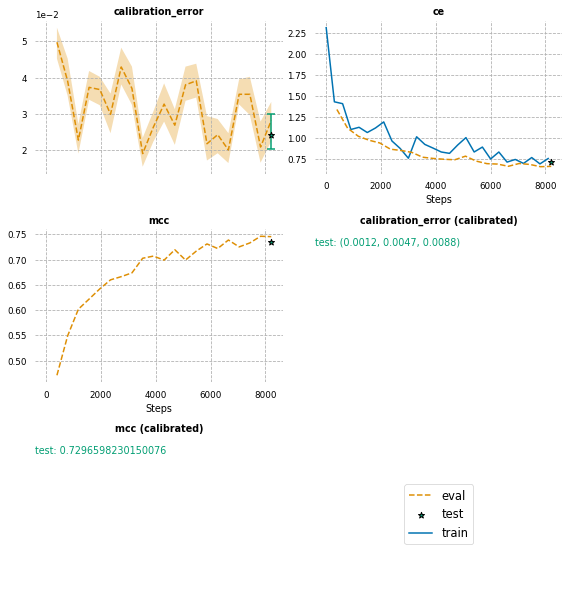

In [10]:
visualize_logs([summary], include_metrics={'calibration_error', 'mcc', 'ce', "calibration_error (calibrated)", "mcc (calibrated)"})

In [11]:
delta = summary.history['test']['mcc (calibrated)'][8211] - summary.history['test']['mcc'][8211]
relative_delta = delta / summary.history['test']['mcc'][8211]
print(f"mcc change after calibration: {delta} ({relative_delta*100}%)")

mcc change after calibration: -0.004257430229358206 (-0.5800967630257695%)


In [12]:
delta = summary.history['test']['calibration_error (calibrated)'][8211].y - summary.history['test']['calibration_error'][8211].y
relative_delta = delta / summary.history['test']['calibration_error'][8211].y
print(f"calibration error change after calibration: {delta} ({relative_delta*100}%)")

calibration error change after calibration: -0.0195 (-80.57851239669421%)


As we can see from the graphs and values above, with the use of a platt binning marginal calibrator we can dramatically reduce a model's calibration error (in this case by over 80%) while sacrificing only a very small amount of model performance (in this case less than a 1% reduction in MCC). 